# Define the transforms for the data

In [17]:
import cv2
import numpy as np
from albumentations import ImageOnlyTransform

# Custom Fog Effect
class AddFog(ImageOnlyTransform):
    def __init__(self, p=1.0, fog_intensity=0.5):
        super().__init__(p)
        self.fog_intensity = fog_intensity

    def apply(self, image, **params):
        # Create a white fog overlay (semi-transparent)
        fog = np.ones_like(image, dtype=np.uint8) * 255  # White image
        fog = cv2.GaussianBlur(fog, (15, 15), 0)  # Slight blur to soften the fog
        # Apply some noise to simulate the randomness in fog
        noise = np.random.normal(0, 25, fog.shape).astype(np.uint8)
        fog = cv2.add(fog, noise)  # Add random noise to the fog

        # Blend the fog with the original image
        fogged_image = cv2.addWeighted(image, 1 - self.fog_intensity, fog, self.fog_intensity, 0)
        return fogged_image

# Custom Rain Effect
class AddRain(ImageOnlyTransform):
    def __init__(self, p=1.0, rain_intensity=0.5, num_drops=100):
        super().__init__(p)
        self.rain_intensity = rain_intensity
        self.num_drops = num_drops

    def apply(self, image, **params):
        # Create a copy of the image
        rain_image = image.copy()

        # Randomly create vertical lines (raindrops)
        for _ in range(self.num_drops):
            x1 = np.random.randint(0, image.shape[1])
            y1 = np.random.randint(0, image.shape[0])
            x2 = x1 + np.random.randint(2, 5)  # Small width for raindrops
            y2 = y1 + np.random.randint(20, 50)  # Random height for each raindrop

            # Draw the raindrop (a vertical line)
            cv2.line(rain_image, (x1, y1), (x2, y2), (255, 255, 255), 1)

        # Blend the rain image with the original image (based on intensity)
        rain_image = cv2.addWeighted(rain_image, 1 - self.rain_intensity, image, self.rain_intensity, 0)
        return rain_image


In [47]:
from albumentations import Compose, MotionBlur, GaussianBlur, RandomBrightnessContrast
from albumentations import RandomGamma, CLAHE, GaussNoise, ElasticTransform, GridDistortion
from albumentations import HueSaturationValue, Solarize, CoarseDropout, Resize
from albumentations import ChannelShuffle, CenterCrop, Blur, ShiftScaleRotate
from albumentations import Perspective, Equalize, InvertImg, ChannelDropout

# Define the full augmentation pipeline
def resize_to_original(image, original_shape, **kwargs):
    return cv2.resize(image, (original_shape[1], original_shape[0]))

transformations = Compose([
    # Simulate bird in motion (motion blur)
    MotionBlur(p=1.0, blur_limit=7),

    # General blur (could represent a shaky or unfocused camera)
    GaussianBlur(sigma_limit=(1.0,5.0), blur_limit=(3, 7), p=1.0),

    # Simulate varying distances (zoom in/out, crop)
    Compose([
        CenterCrop(height=100, width=100, p=1.0),
        Resize(height=333, width=500, p=1.0),
    ], p=1.0),

    # Rotate and shift the image (simulate slight rotations and camera shake)
    ShiftScaleRotate(shift_limit=(-0.3,0.3), scale_limit=(-0.5,0.5), rotate_limit=(-25,25), p=1.0),

    # Simulate noisy or poor-quality images (by dropping pixels)
    CoarseDropout(hole_height_range=(10, 20), hole_width_range=(10, 50), fill='inpaint_telea', p=1.0),

    # Simulate distortion effects (camera shake or image distortions)
    ElasticTransform(alpha=10, sigma=30, p=1.0),

    # Simulate rapid shifts (shaky camera)
    GridDistortion(num_steps=5, distort_limit=0.3, p=1.0),

    # Change color tones (lighting conditions, different environments)
    HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=1.0),

    # Standard transformations
    Perspective(scale=(0.05, 5), p=1.0),
    GaussNoise(std_range=(0.1, 0.35), p=1.0),
    RandomGamma(gamma_limit=(80, 120), p=1.0),
    CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=1.0),
    ChannelShuffle(p=1.0),
    Equalize(p=1.0),
    Solarize(threshold_range=[0.3, 0.5], p=1.0),
    InvertImg(p=1.0),
    ChannelDropout(p=1.0),
    Blur(blur_limit=7, p=1.0),

    # Simulate poor contrast, underexposure, or low-light conditions
    RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=1.0),

    # Custom Fog Effect
    AddFog(p=1.0, fog_intensity=0.5),

    # Custom Rain Effect
    AddRain(p=1.0, rain_intensity=0.5, num_drops=500),
])


/home/sashankh-ravi/anaconda3/envs/birdappenv1/lib/python3.10/site-packages/albumentations/core/validation.py:45: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


## Run transformations for all images in parallel

In [48]:
import cv2
import concurrent.futures
import os

# Function to apply each transformation individually and save it
def apply_and_save_transformations(image, original_img_path, output_dir, image_label, transformations):
    for idx, transform in enumerate(transformations):
        augmented = transform(image=image)
        augmented_image = augmented['image']

        # Generate a new filename for the transformed image
        filename = f"{os.path.splitext(os.path.basename(original_img_path))[0]}_transformation_{idx}.jpg"
        output_path = os.path.join(output_dir, image_label, filename)

        # Ensure the directory exists
        os.makedirs(os.path.dirname(output_path), exist_ok=True)

        # Save the transformed image
        cv2.imwrite(output_path, augmented_image)

# Directory containing your images (update this to your folder)
input_dir = "/home/sashankh-ravi/Documents/Datasets/iNet_Bird_Small/train"
output_dir = "/home/sashankh-ravi/Documents/Datasets/iNet_Bird_Small/train_transformed"

# Function to apply transformations in parallel to all images in the dataset
def process_images_in_parallel(input_dir, output_dir, transformations):
        # Iterate through each category (sub-folder) in the training dataset
    # with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []

        for category in os.listdir(input_dir)[:1]:
            category_path = os.path.join(input_dir, category)
            image_label = category.split("/")[-1]
            print(category_path)

            if os.path.isdir(category_path):
                # Iterate through each image in the category folder
                for img_name in os.listdir(category_path)[:1]:
                    img_path = os.path.join(category_path, img_name)
                    print(img_path)
                    if os.path.isfile(img_path):
                        image = cv2.imread(img_path)

                        apply_and_save_transformations(image, img_path, output_dir, image_label, transformations)

        #                 # Submit the image processing task to the executor (parallelize the work)
        #                 futures.append(executor.submit(apply_and_save_transformations, image, img_path, output_dir))

        # # Wait for all futures to complete
        # for future in concurrent.futures.as_completed(futures):
        #     future.result()  # Ensures all transformations are applied and saved

# Apply transformations in parallel to all images in the training dataset
process_images_in_parallel(input_dir, output_dir, transformations)


/home/sashankh-ravi/Documents/Datasets/iNet_Bird_Small/train/03686_Animalia_Chordata_Aves_Passeriformes_Acrocephalidae_Acrocephalus_scirpaceus
/home/sashankh-ravi/Documents/Datasets/iNet_Bird_Small/train/03686_Animalia_Chordata_Aves_Passeriformes_Acrocephalidae_Acrocephalus_scirpaceus/ec4ec092-d5ae-4583-ba17-bbba829f54b7.jpg


In [26]:
import cv2
images = cv2.imread("/home/sashankh-ravi/Documents/Datasets/iNet_Bird_Small/train/03111_Animalia_Chordata_Aves_Accipitriformes_Accipitridae_Accipiter_badius/1c024a3c-adf4-437e-9c50-b8e9984c072f.jpg")
augmented = transform(image=images)
augmented_image = augmented['image']

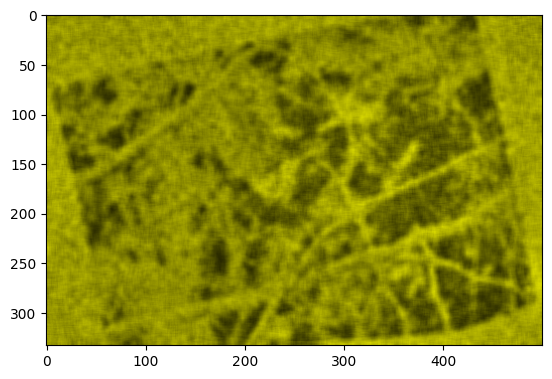

In [27]:
import matplotlib.pyplot as plt
plt.imshow(augmented_image)

In [ ]:
import os
import cv2
from concurrent.futures import ProcessPoolExecutor

# Path to your training folder
train_path = "/home/sashankh-ravi/Documents/Datasets/iNet_Bird_Small/train"
output_path = "/home/sashankh-ravi/Documents/Datasets/iNet_Bird_Small/train_transformed"

# Function to apply augmentations and save the transformed image
def process_image(img_path, category_path, transform):
    image = cv2.imread(img_path)
    augmented = transform(image=image)
    augmented_image = augmented['image']
    
    # Create a new path for the augmented image
    augmented_img_path = os.path.join(output_path, os.path.basename(category_path), f"aug_{os.path.basename(img_path)}")
    
    # Ensure the category folder exists in the output directory
    os.makedirs(os.path.dirname(augmented_img_path), exist_ok=True)
    
    # Save the augmented image
    cv2.imwrite(augmented_img_path, augmented_image)

# Function to apply transformations to all images in a folder
def augment_images_in_folder(category_path):
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        if os.path.isfile(img_path):
            process_image(img_path, category_path, transform)

# Parallel processing to apply transformations to the training dataset
def process_dataset_in_parallel():
    with ProcessPoolExecutor() as executor:
        # Iterate through each category (sub-folder) in the training dataset
        for category in os.listdir(train_path):
            category_path = os.path.join(train_path, category)
            if os.path.isdir(category_path):
                executor.submit(augment_images_in_folder, category_path)

# Run the augmentation in parallel
process_dataset_in_parallel()


In [ ]:
import os
import cv2
from concurrent.futures import ProcessPoolExecutor

# Path to your training folder
train_path = "/home/sashankh-ravi/Documents/Datasets/iNet_Bird_Small/train"
output_path = "/home/sashankh-ravi/Documents/Datasets/iNet_Bird_Small/train_transformed"

# Function to apply augmentations and save the transformed image
def process_image(img_path, category_path, transform):
    image = cv2.imread(img_path)
    augmented = transform(image=image)
    augmented_image = augmented['image']
    
    # Create a new path for the augmented image
    augmented_img_path = os.path.join(output_path, os.path.basename(category_path), f"aug_{os.path.basename(img_path)}")
    
    # Ensure the category folder exists in the output directory
    os.makedirs(os.path.dirname(augmented_img_path), exist_ok=True)
    
    # Save the augmented image
    cv2.imwrite(augmented_img_path, augmented_image)

# Function to apply transformations to all images in a folder
def augment_images_in_folder(category_path):
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        if os.path.isfile(img_path):
            process_image(img_path, category_path, transform)

# Parallel processing to apply transformations to the training dataset
def process_dataset_in_parallel():
    with ProcessPoolExecutor() as executor:
        # Iterate through each category (sub-folder) in the training dataset
        for category in os.listdir(train_path):
            category_path = os.path.join(train_path, category)
            if os.path.isdir(category_path):
                executor.submit(augment_images_in_folder, category_path)

# Run the augmentation in parallel
process_dataset_in_parallel()
